<font size=8>Quantum Fourier Transform</font>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import qiskit
%config InlineBackend.figure_format="svg"

# Keywords

## 5.1 Quantum Fourier Transform
Discrete Fourier Transofrm, Quantum Fourier Transform, product representation and implementation.

## 5.2 Phase Estimation
Phase estimation,
1. consititution.: t register, u register, black box.
2. procedure: superpositio (H gates), black box, inverse QFT, measusrement.
3. $t=n+\lceil\log(2+\frac{1}{2\epsilon})\rceil$ to obtain $\phi$ in $n$ bits with probability $\geq 1-\epsilon$.

Not read yet: 5.3.1 (only skim through), 5.3, 5.4

# Solutions

## 5.1
**Exercise 5.4**: Give a decomposition of the controlled-Rk gate into single qubit and CNOT gates.

*Solution*. To decompose $$R_k = \begin{bmatrix}1 &0 \\ 0 &e^{2\pi i / 2^k}  \end{bmatrix},$$
We may use the Z-X decomposition and its corollary stated in theorem 4.1. First, $R_k$ can be Z-X decomposed into $R_k=e^{i\alpha}R_z(\beta)R_y(\gamma)R_z(\delta)$ with $\alpha = 2\pi / 2^{k+1}$, $\gamma = 0$ and $\delta = 2\pi/2^k$. We can further decompose it into $U=e^{i\alpha} AXBXC$ with $A=I$, $B=R_z(-2\pi / 2^{k+1})$, $C=R_z(2\pi / 2^{k+1})$. The controlled gate is then given by $$\mathrm{C}R_k = e^{i\alpha}(\mathrm{CX})B(\mathrm{CX})C,$$ where $\mathrm{CX}$ is the CNOT gate. Of course, in qiskit this gate is directly supported supported.

In [7]:
from qiskit.circuit.library import CPhaseGate
CP2 = CPhaseGate(2 * np.pi / 2**2)
CP2

Instruction(name='cp', num_qubits=2, num_clbits=0, params=[1.5707963267948966])

# Implementation
## QFT
Quantum Fourier Transform is defined by
$$\begin{aligned}
|j\rangle &\to \frac{1}{2^{n/2}}\sum_{k=0}^{2^n-1}e^{i(2\pi jk/2^n)}|k\rangle.\\
&=\frac{1}{2^{n/2}}(|0\rangle + e^{2\pi i 0.j_n}|1\rangle)(|0\rangle + e^{2\pi i 0.j_{n-1}j_n}|1\rangle)\dots(|0\rangle + e^{2\pi i 0.j_1j_2\dots j_n}|1\rangle)
\end{aligned}$$
It can be implemented in the following.
Note that in qiskit, the bit ordering is like $|q_nq_{n-1}\dots q_0\rangle$, so that the binary number represented by this state vector is precisely $\sum_k2^kq_k$. This is somewhat the reverse of the text book.

In [73]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector

In [54]:
def my_QFT(bits: int) -> QuantumCircuit:
    qc = QuantumCircuit(bits)
    for k in range(bits):
        target = bits-1-k
        qc.h(target)
        # R gate
        n_r = bits - k  # number of R_gate
        for m in range(2, n_r + 1):
            theta = 2 * np.pi / 2**m
            qc.cp(theta, target-(m-1), target, label=f"R_{m}")
    # swap
    for i in range(bits // 2):
        qc.swap(i, bits-1-i)
    return qc

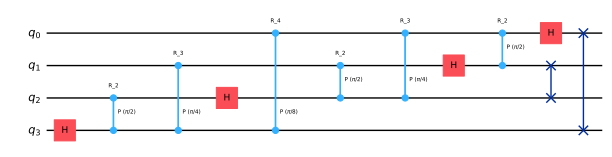

In [56]:
qft_4 = my_QFT(4)
qft_4.draw("mpl",scale=0.7)

Let's test the QFT circuit through a simulation. In the following, I will compare the result of a traditional result of FFT and the result of QFT. Note that the sign defined in scipy is different from our QFT, what corresponds to the QFT in text book is actually inverse fft in scipy.

In [57]:
from scipy.fft import ifft
init_state = np.array([1., 1.5, 0.5, 0.7])
init_state /= np.linalg.norm(init_state)
classical = ifft(init_state, norm="ortho")
print(classical)

[ 0.92615842-0.j          0.12515654+0.20025047j -0.17521916-0.j
  0.12515654-0.20025047j]


In [58]:
a, b, c, d = init_state
q = a * Statevector.from_label("00") + b * Statevector.from_label("01") \
    + c * Statevector.from_label("10") + d * Statevector.from_label("11")
# This is not possible in practice, but how is init state be prepared in practice?
qc = my_QFT(2)
quantum = q.evolve(qc)
quantum

Statevector([ 0.92615842+0.j        ,  0.12515654+0.20025047j,
             -0.17521916+0.j        ,  0.12515654-0.20025047j],
            dims=(2, 2))


In [59]:
# classical and quantum coincides
np.allclose(classical, quantum.data)

True

Note that QFT has already been implemented in qiskit:

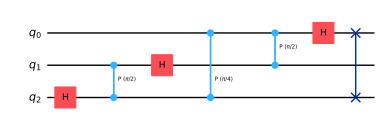

In [61]:
from qiskit.circuit.library import QFT
qc_test = QFT(3)
# q.evolve(qc_test)
qc_test.decompose().draw("mpl", scale=0.7)

## Phase estimation
In the following, I will try to use phase eistimation to estimate the following matrix
$$\begin{bmatrix}
1 &0 \\
1 & e^{i(2\pi\phi)}
\end{bmatrix}$$
with $\phi = 1/2 + 1/4 + 1/8 = 0.875$. This is an ideal case where $\phi$ can be precisely decomposed into a "binary fraction", so we only need to use $t=3$ bits for the estimation. If the simulation doesn't go wrong, the measured result will be "111" with probability 1.

In [85]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from qiskit.primitives import Sampler
import numpy as np

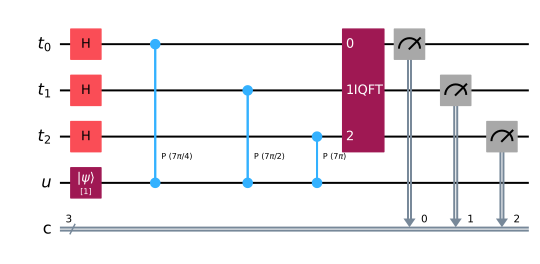

In [86]:
t_size = 3
phi = .875
t = QuantumRegister(size=t_size, name="t")
u = QuantumRegister(size=1, name="u")
c = ClassicalRegister(size=3, name="c")
pe_qc = QuantumCircuit(t, u, c)
pe_qc.initialize("1", u[0])
for i in range(t_size):
    pe_qc.h(t[i])
for i in range(t_size):
    theta = (2 * np.pi * phi) * 2**i
    pe_qc.cp(theta, i, u[0])
pe_qc.append(QFT(t_size, inverse=True), t[:])
for i in range(t_size):
    pe_qc.measure(t[i], c[i])
pe_qc.draw("mpl")

In [89]:
# Sampling
sampler = Sampler()
job = sampler.run(pe_qc)
result = job.result()
result.quasi_dists[0].binary_probabilities()

{'111': 0.9999999999999992}

Of course, phase estimation have also been implemented in qiskit.

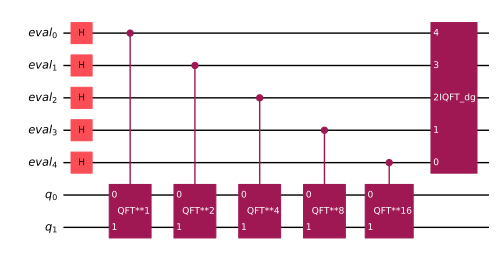

In [96]:
from qiskit.circuit.library import PhaseEstimation, QFT
pe_test = PhaseEstimation(5, QFT(2))  # phase estimation of qft
pe_test.decompose().draw("mpl", scale=0.7)